# ICAレポートアドバンスステップ

米国の映画館運営会社の売上予測モデルを構築

In [ ]:
!pip install pmdarima
!pip install japanize-matplotlib
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.font_manager as fm
import statsmodels.api as sm
import pmdarima as pm
import datetime
import math
import os

In [ ]:
cinema = pd.read_csv('/content/cinemaTicket_Ref.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
cinema

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569,495,1320000,22,0,2,3.86,60000.0,22,569.948187,2018-11-04,11,4,4
142520,1569,474,1200000,15,0,1,65.22,80000.0,15,22.999080,2018-11-04,11,4,4
142521,1569,524,1060000,8,0,3,9.20,132500.0,8,86.956522,2018-11-04,11,4,4
142522,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4


In [ ]:
cinema.describe()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
count,142524.000000,142524.000000,1.425240e+05,142524.000000,142524.000000,142524.000000,142399.000000,142524.000000,142524.000000,142399.000000,142524.000000,142524.000000,142524.000000
mean,1518.985111,320.378427,1.234728e+07,140.137570,0.237413,3.932103,19.965986,81234.599886,139.900157,854.723605,6.776852,2.634721,16.112585
std,36.184450,159.701229,3.065486e+07,279.758733,2.923206,3.056276,22.653445,33236.599278,279.564935,953.118103,2.195843,0.809692,8.949471
min,1471.000000,32.000000,2.000000e+04,1.000000,0.000000,1.000000,0.000000,483.870968,-219.000000,-2.000000,2.000000,1.000000,1.000000
25%,1485.000000,181.000000,1.260000e+06,18.000000,0.000000,2.000000,3.750000,60000.000000,18.000000,276.994486,5.000000,2.000000,8.000000
50%,1498.000000,324.000000,3.720000e+06,50.000000,0.000000,3.000000,10.350000,79454.235185,50.000000,525.714286,7.000000,3.000000,16.000000
75%,1556.000000,474.000000,1.110000e+07,143.000000,0.000000,5.000000,28.210000,100000.000000,143.000000,1038.961039,9.000000,3.000000,24.000000
max,1589.000000,637.000000,1.262820e+09,8499.000000,311.000000,60.000000,147.500000,700000.000000,8499.000000,9692.097160,11.000000,4.000000,31.000000


In [ ]:
cinema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142399 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142399 non-null  float64
 10  date          142524 non-null  object 
 11  month         142524 non-null  int64  
 12  quarter       142524 non-null  int64  
 13  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 15.2+ MB


## 前処理

dateがオブジェクト型のため、datetime型に変更し、インデックスとする。

また、occu_perc,capacityに欠損が見られるため保管していく。

In [ ]:
cinema['date'] = pd.to_datetime(cinema['date'])

In [ ]:
cinema.set_index('date', inplace=True)

occu_percは該当するフィルムコードでの平均で補完

In [ ]:
# occu_percの欠損値を補完
cinema['occu_perc'] = cinema.groupby('film_code')['occu_perc'].transform(lambda x: x.fillna(x.mean()))

同じcinema_codeでどれだけcapacityのばらつきがあるか確認。

In [ ]:
cinema_304 = cinema[cinema['cinema_code'] == 304]
cinema_304.describe()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
count,1963.000000,1963.0,1.963000e+03,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000
mean,1518.687213,304.0,5.180898e+07,400.755986,0.469689,5.007641,40.238492,132444.032140,400.286296,913.361751,6.798777,2.622517,16.004075
std,35.645782,0.0,7.027994e+07,516.106885,2.320514,3.475771,26.480584,26802.308768,515.315551,796.768922,2.186223,0.809376,8.940908
min,1471.000000,304.0,1.500000e+05,1.000000,0.000000,1.000000,0.450000,60000.000000,1.000000,146.945089,3.000000,1.000000,1.000000
25%,1486.000000,304.0,1.155000e+07,88.000000,0.000000,3.000000,17.460000,119559.178588,88.000000,440.995854,5.000000,2.000000,8.000000
50%,1499.000000,304.0,2.745000e+07,217.000000,0.000000,4.000000,34.710000,148046.875000,216.000000,610.965462,7.000000,3.000000,16.000000
75%,1557.000000,304.0,6.262500e+07,493.500000,0.000000,6.000000,61.180000,150000.000000,493.500000,1189.273781,9.000000,3.000000,24.000000
max,1589.000000,304.0,6.289500e+08,4276.000000,23.000000,25.000000,100.000000,150000.000000,4276.000000,5301.264567,11.000000,4.000000,31.000000


最小値から最大値に大きな差があるため、今回は中央値にて補完する。

In [ ]:
# capacityの欠損を補完
cinema['capacity'] = cinema.groupby('cinema_code')['capacity'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# cinema_code ごとの capacity の欠損状況を確認
capacity_missing_by_cinema_code = cinema.groupby('cinema_code')['capacity'].apply(lambda x: x.isnull().sum())

# capacity の値がすべて欠損している cinema_code を特定
cinema_codes_with_all_missing_capacity = capacity_missing_by_cinema_code[capacity_missing_by_cinema_code == cinema.groupby('cinema_code')['capacity'].size()].index

# 特定した cinema_code に対して全体の median 値で補完
overall_median = cinema['capacity'].median()
for cinema_code in cinema_codes_with_all_missing_capacity:
    cinema.loc[cinema['cinema_code'] == cinema_code, 'capacity'] = overall_median

# 再度 groupby と transform を使って欠損値補完
cinema['capacity'] = cinema.groupby('cinema_code')['capacity'].transform(lambda x: x.fillna(x.median()))

In [ ]:
cinema.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142524 entries, 2018-05-05 to 2018-11-04
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142524 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142524 non-null  float64
 10  month         142524 non-null  int64  
 11  quarter       142524 non-null  int64  
 12  day           142524 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 15.2 MB


In [ ]:
cinema.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
date,,,,,,,,,,,,,
2018-05-05,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,5,2,5
2018-05-05,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,5,2,5
2018-05-05,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,5,2,5
2018-05-05,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,5,2,5
2018-05-05,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,5,2,5


In [ ]:
dayly_sales = cinema['total_sales'].resample('D').sum()  # 日単位で合計を計算

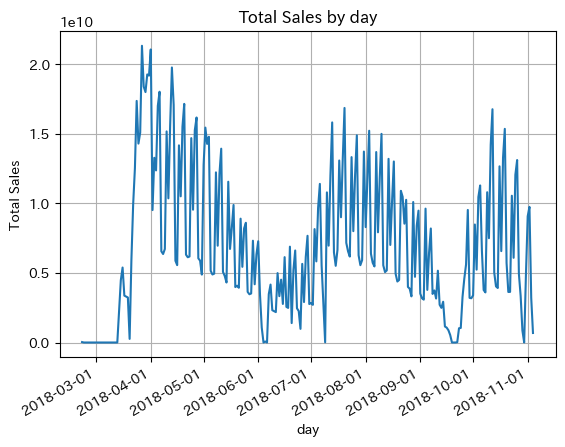

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(dayly_sales.index,dayly_sales.values)
plt.xlabel('day')
plt.ylabel('Total Sales')
plt.title('Total Sales by day')

# x軸の目盛を調整し、見やすくする
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # x軸のラベルを回転させて見やすくする

plt.grid(True)
plt.show()

In [ ]:
weekly_sales = cinema['total_sales'].resample('w').sum()  # 週単位で合計を計算

<ipython-input-225-9134cc41ec92>:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_sales = cinema['total_sales'].resample('w').sum()  # 週単位で合計を計算


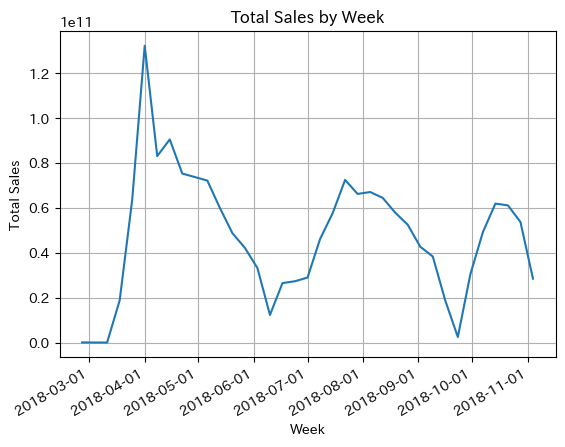

In [ ]:
plt.plot(weekly_sales.index, weekly_sales.values)
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.title('Total Sales by Week')

# x軸の目盛を調整し、見やすくする
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # x軸のラベルを回転させて見やすくする

plt.grid(True)
plt.show()

### daily_salesとしてデータフレームを作成、分析していく。

日次の方が動きを捉えやすいため、売上を日ごとに集計し、daily_salesとしてデータフレームを作成、分析していく。

In [ ]:
daily_sales = cinema.groupby('date')['total_sales'].sum().reset_index()
print(daily_sales)

          date  total_sales
0   2018-02-21     32030000
1   2018-02-23       180000
2   2018-03-14   2202300484
3   2018-03-15   4479008974
4   2018-03-16   5386645987
..         ...          ...
229 2018-10-31   4871998000
230 2018-11-01   9071854998
231 2018-11-02   9744695000
232 2018-11-03   3208490000
233 2018-11-04    682985000

[234 rows x 2 columns]


In [ ]:
# dateをdatetime型に変更
daily_sales['date'] = pd.to_datetime(daily_sales['date'])

In [ ]:
# dateをインデックスに設定
daily_sales.set_index('date', inplace=True)

In [ ]:
print(daily_sales)

            total_sales
date                   
2018-02-21     32030000
2018-02-23       180000
2018-03-14   2202300484
2018-03-15   4479008974
2018-03-16   5386645987
...                 ...
2018-10-31   4871998000
2018-11-01   9071854998
2018-11-02   9744695000
2018-11-03   3208490000
2018-11-04    682985000

[234 rows x 1 columns]


Text(0.5, 1.0, 'Total Sales by day')

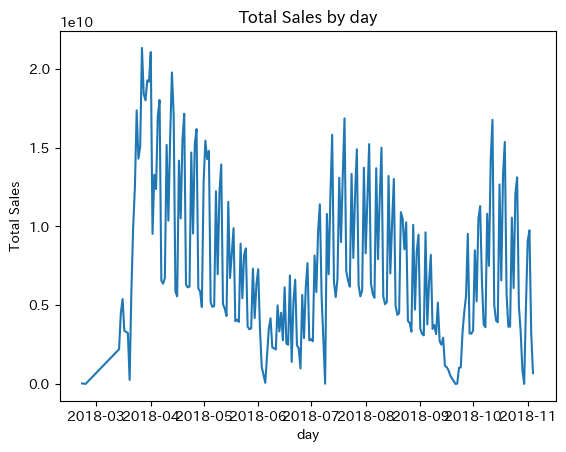

In [ ]:
plt.plot(daily_sales.index, daily_sales.total_sales)
plt.xlabel('day')
plt.ylabel('Total Sales')
plt.title('Total Sales by day')

### ACF/PACF,seasonal_decomposeの実行

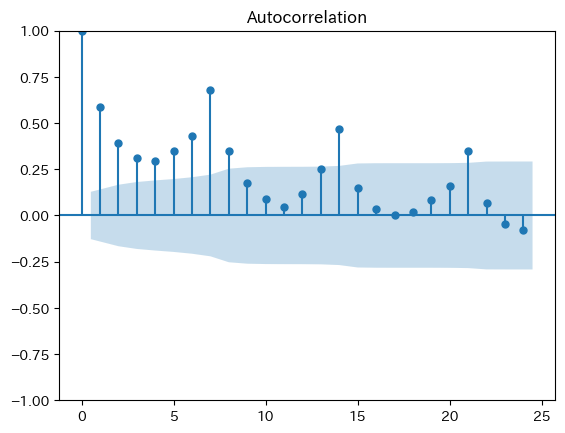

In [ ]:
sm.graphics.tsa.plot_acf(daily_sales.total_sales)
plt.show()

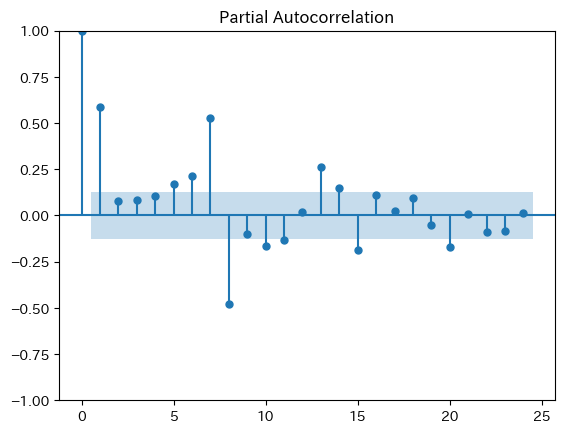

In [ ]:
sm.graphics.tsa.plot_pacf(daily_sales.total_sales)
plt.show()

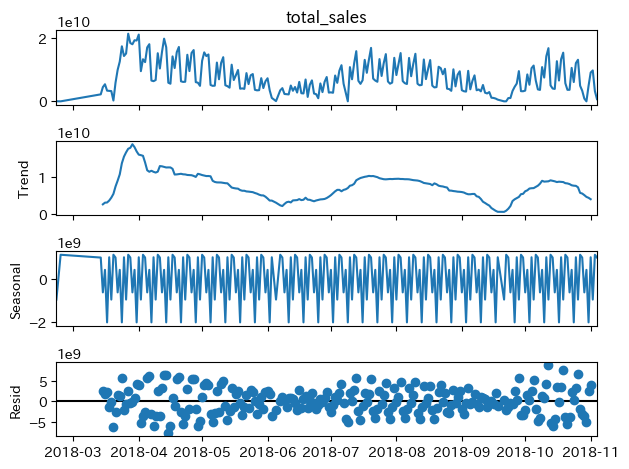

In [ ]:
# seasonal_decomposeで分解
result = sm.tsa.seasonal_decompose(daily_sales.total_sales, model='additive', period=7)  # periodは季節性の周期(例:週次データなら7)

# 分解結果の可視化
result.plot()
plt.show()

**定常/非定常**

3月～6月、7月～9月、10月～11月にかけてばらつきがみられるため、非定常である。山が3つあるため4次多項式？

**トレンド**

3月～6月は下降トレンド、7月～9月、10月～11月にかけては重要が高く、トレンドがある。これを取り除くことで定常にできそう。

**季節性**

データ自体が2018年3月～11月までのため、季節性を観測することは難しいが、春休みや夏休みなどの大型連休には需要増が考えられるため、季節性は発生しそう。

3月が春休みシーズンのため、需要が高く、6月にかけて売り上げが減少しているよう。また、6月下旬～8月中旬にかけては夏休みシーズンのため売上増が考えられる。10月にも売り上げが増加しているが、この時期に連休はないようなので、話題作が上映されたのかもしれない。

### 階差を表示し確認

4次多項式のようなグラフのため、4次まで階差を表示し確認する。

In [ ]:
daily_sales['diff1'] = daily_sales['total_sales'].diff(1)
daily_sales['diff2'] = daily_sales['diff1'].diff(1)
daily_sales['diff3'] = daily_sales['diff2'].diff(1)
daily_sales['diff4'] = daily_sales['diff3'].diff(1)

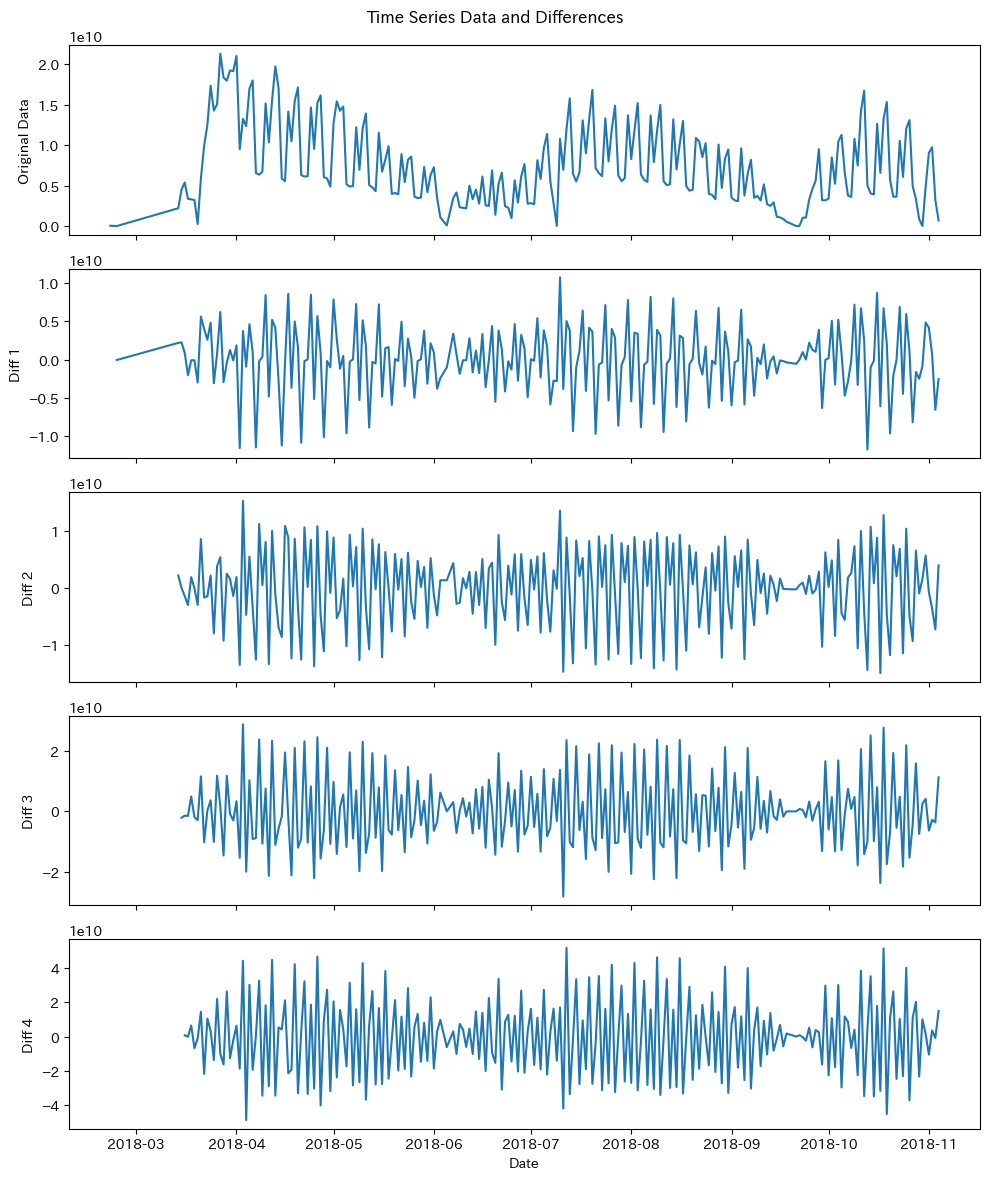

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# 元データ
axes[0].plot(daily_sales['total_sales'], label='Original')
axes[0].set_ylabel('Original Data')

# 1次階差
axes[1].plot(daily_sales['diff1'], label='Diff 1')
axes[1].set_ylabel('Diff 1')

# 2次階差
axes[2].plot(daily_sales['diff2'], label='Diff 2')
axes[2].set_ylabel('Diff 2')

# 3次階差
axes[3].plot(daily_sales['diff3'], label='Diff 3')
axes[3].set_ylabel('Diff 3')

# 4次階差
axes[4].plot(daily_sales['diff4'], label='Diff 4')
axes[4].set_ylabel('Diff 4')

plt.xlabel('Date')
plt.suptitle('Time Series Data and Differences')
plt.tight_layout()
plt.show()

Diff1とDiff2で少し差があるが、これは階差を取りすぎだと考えるため、階差を取る回数は1回とする。

In [ ]:
daily_sales['diff1'] = daily_sales['total_sales'].diff(1)

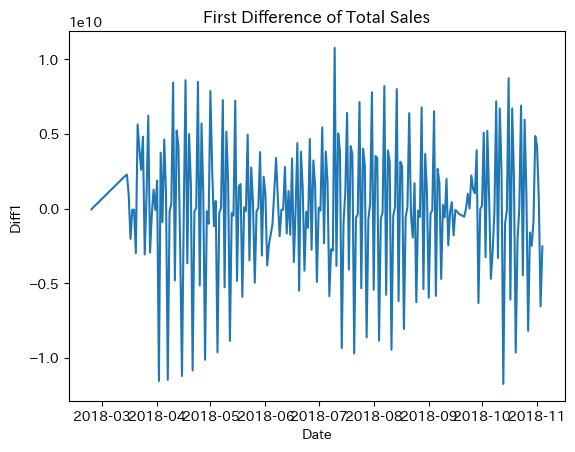

In [ ]:
plt.plot(daily_sales.index, daily_sales['diff1'])
plt.xlabel('Date')
plt.ylabel('Diff1')
plt.title('First Difference of Total Sales')
plt.show()

### 季節性の除去

トレンドが省けたので、続いて季節性も取り除いていく。

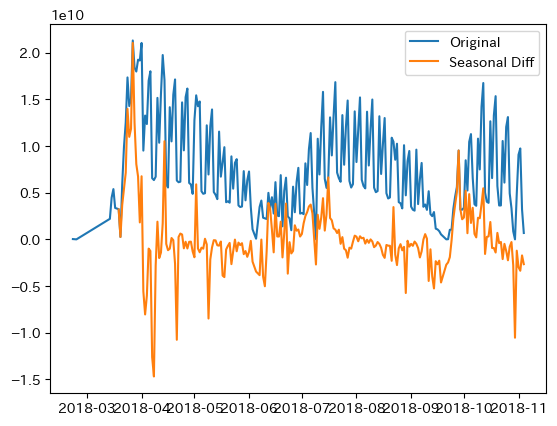

In [ ]:
# 7日前のデータとの差分を計算
daily_sales['seasonal_diff'] = daily_sales['total_sales'].diff(7)

# 可視化
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Original')
plt.plot(daily_sales.index, daily_sales['seasonal_diff'], label='Seasonal Diff')
plt.legend()
plt.show()

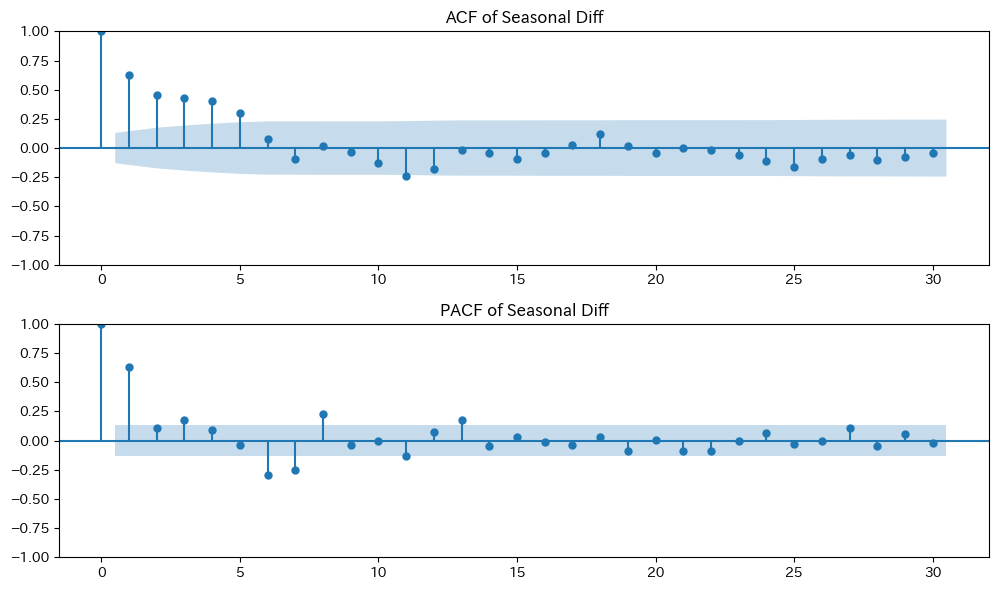

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACFの描画
sm.graphics.tsa.plot_acf(daily_sales['seasonal_diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('ACF of Seasonal Diff')

# PACFの描画
sm.graphics.tsa.plot_pacf(daily_sales['seasonal_diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('PACF of Seasonal Diff')

plt.tight_layout()
plt.show()

また、季節性が見られるので、他の差分でも確認してみる。

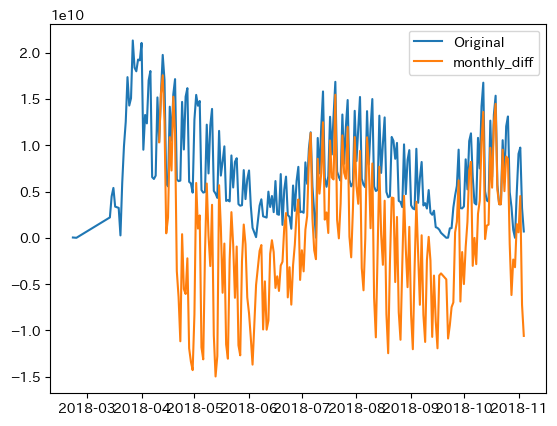

In [ ]:
# 月次で差分をとる
daily_sales['monthly_diff'] = daily_sales['total_sales'].diff(30)

# 可視化
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Original')
plt.plot(daily_sales.index, daily_sales['monthly_diff'], label='monthly_diff')
plt.legend()
plt.show()

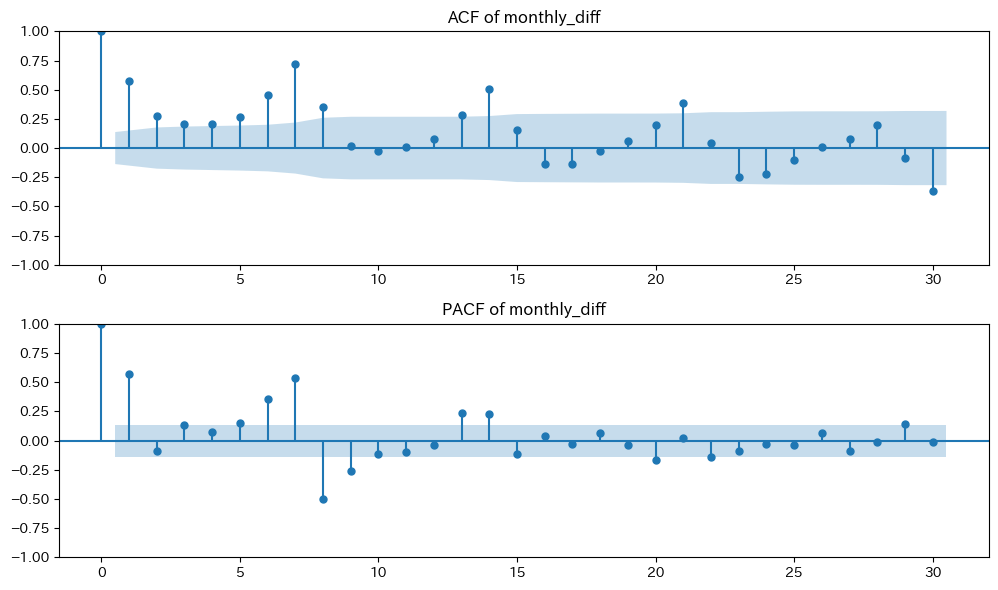

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACFの描画
sm.graphics.tsa.plot_acf(daily_sales['monthly_diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('ACF of monthly_diff')

# PACFの描画
sm.graphics.tsa.plot_pacf(daily_sales['monthly_diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('PACF of monthly_diff')

plt.tight_layout()
plt.show()

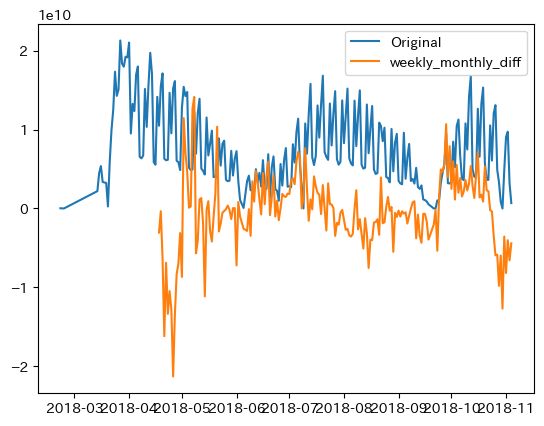

In [ ]:
daily_sales['weekly_diff'] = daily_sales['total_sales'].diff(7)
daily_sales['weekly_monthly_diff'] = daily_sales['weekly_diff'].diff(30)

# 可視化
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Original')
plt.plot(daily_sales.index, daily_sales['weekly_monthly_diff'], label='weekly_monthly_diff')
plt.legend()
plt.show()

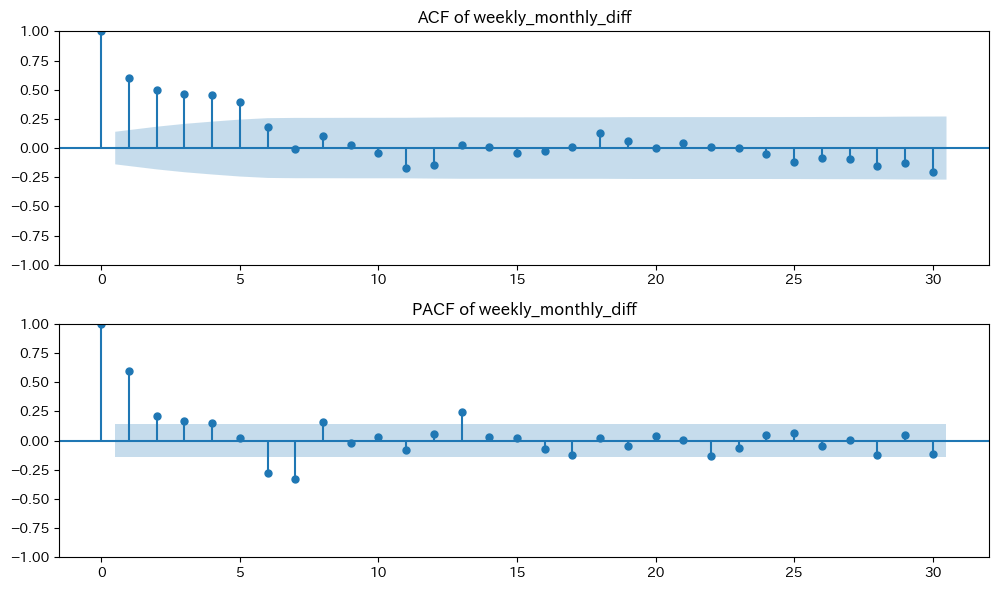

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACFの描画
sm.graphics.tsa.plot_acf(daily_sales['weekly_monthly_diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('ACF of weekly_monthly_diff')

# PACFの描画
sm.graphics.tsa.plot_pacf(daily_sales['weekly_monthly_diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('PACF of weekly_monthly_diff')

plt.tight_layout()
plt.show()

週次の差分が一番適切だと考え、分析を進めていく。

このデータは季節性もあるため、SARIMAモデル(p,d,q)(P,D,Q)sにてモデリングしていく。

**階差・周期 d,D,s**

階差1、季節性あり、季節階差7 ⇒d=1,D=1,s=7

 **自己相関解析**

【季節外部分】

ACF 指数的な減衰が見られる⇒ MA(0) ⇒q⁼0

PACF 1でカットオフ ->MA(1)⇒ p=1

【季節部分】

ACF SMA(Q)⇒0

PACF SAR(P) ⇒2

**SARIMA(1,1,0)(2,1,0)7でモデリング**

## SARIMAモデルの構築

In [ ]:
# SARIMAモデルの構築
model = sm.tsa.SARIMAX(daily_sales['total_sales'], order=(1, 1, 0), seasonal_order=(2, 1, 0, 7))
results = model.fit()

# 残差の取得
residuals = results.resid

# Ljung-Box検定の実行
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

# 検定結果の表示
print(ljung_box_results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


      lb_stat  lb_pvalue
10  22.270849   0.013783


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       total_sales   No. Observations:                  234
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -5243.002
Date:                           Thu, 19 Dec 2024   AIC                          10494.004
Time:                                   21:03:57   BIC                          10507.686
Sample:                                        0   HQIC                         10499.526
                                           - 234                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2845      0.067     -4.225      0.000      -0.416      -0.153
ar.S.L7       -0.4700      0.071     -6.664      0.000      -0.608      -0.332
ar.S.L14      -0.1174      0.074     -1.576      0.115      -0.263       0.029
sigma2      9.881e+18   7.08e-21    1.4e+39      0.000    9.88e+18    9.88e+18
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               118.89
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.67
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+54. Standard errors may be unstable.
"""

Ljung-Box Testの結果H0(残差はホワイトノイズである)を棄却してしまうため、H1(残差は白色ノイズでなく、自己相関が存在する)となる。

対数変換を行い、再検討をする。

## 対数変換にて再検討

In [ ]:
daily_sales['total_sales_log']= np.log(daily_sales['total_sales'])

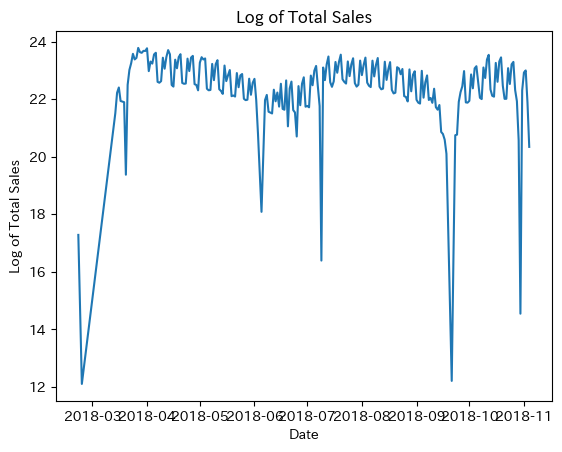

In [ ]:
plt.plot(daily_sales.index, daily_sales['total_sales_log'])
plt.xlabel('Date')
plt.ylabel('Log of Total Sales')
plt.title('Log of Total Sales')
plt.show()

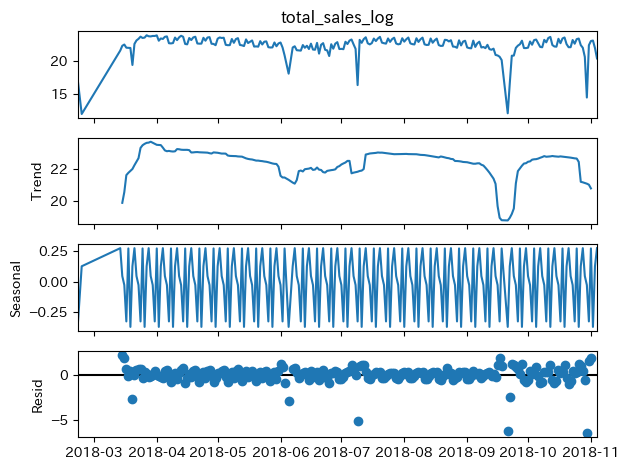

In [ ]:
# seasonal_decomposeで分解
result = sm.tsa.seasonal_decompose(daily_sales.total_sales_log, model='additive', period=7)  # periodは季節性の周期(例:週次データなら7)

# 分解結果の可視化
result.plot()
plt.show()

## Box-Cox変換

対数変換を行ったが、いくつかのイレギュラがあることが判明。
このイレギュラーの対処をするため、Box-Cox変換を実行してみる。

In [ ]:
from scipy import stats
from scipy.special import inv_boxcox

In [ ]:
# total_sales列にBox-Cox変換を適用
data_transformed, lambda_ = stats.boxcox(daily_sales['total_sales'])

# 変換後のデータを新しい列に追加
daily_sales['total_sales_boxcox'] = data_transformed

# 変換パラメータを表示
print(f"Box-Cox変換パラメータ (λ): {lambda_}")

Box-Cox変換パラメータ (λ): 0.5148648098103369


In [ ]:
# Box-Cox変換後のデータに対してauto_arimaを実行
model = pm.auto_arima(daily_sales['total_sales_boxcox'],
                      seasonal=True, m=7, # 季節性は週次データなのでm=7
                      d=1, D=1,          # 階差の次数は事前に決定しておく
                      start_p=0, start_q=0, max_p=3, max_q=3,
                      start_P=0, start_Q=0, max_P=3, max_Q=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# 最適なパラメータを表示
print(model.order, model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5613.123, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5561.294, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=5546.383, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=5584.267, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[7]             : AIC=5547.636, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[7]             : AIC=5547.657, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=5549.648, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[7]             : AIC=5549.628, Time=0.66 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=5569.260, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=5542.329, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=5576.133, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[7]             : AIC=5544.104, Time=0.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[7]             : AIC=5544.121, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[7]             : AIC=5547.239, Time=0.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[7]             : AIC=5546.103, Time=0.76 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=5559.120, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[7]             : AIC=5542.623, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[7]             : AIC=5540.002, Time=0.38 sec
 ARIMA(1,1,2)(0,1,0)[7]             : AIC=5580.219, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[7]             : AIC=5541.828, Time=0.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[7]             : AIC=5541.847, Time=1.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[7]             : AIC=5545.381, Time=1.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,2)[7]             : AIC=5543.818, Time=3.04 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=5538.474, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,0)[7]             : AIC=5578.251, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,1)[7]             : AIC=5540.342, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[7]             : AIC=5540.354, Time=0.35 sec
 ARIMA(0,1,2)(1,1,0)[7]             : AIC=5544.281, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,1,2)[7]             : AIC=5542.337, Time=0.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,1,1)[7]             : AIC=5539.804, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,1)[7]             : AIC=5541.545, Time=0.73 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[7] intercept   : AIC=5542.924, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,1,1)[7]          
Total fit time: 14.319 seconds
(0, 1, 2) (0, 1, 1, 7)


In [ ]:
# SARIMAモデルの構築 (変換後のデータを使用)
model = sm.tsa.SARIMAX(daily_sales['total_sales_boxcox'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 7))
boxcox_results1 = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# 残差の取得
boxcox_residuals = boxcox_results1.resid

# Ljung-Box検定の実行
ljung_box_boxcox_residuals = sm.stats.acorr_ljungbox(boxcox_residuals, lags=[10], return_df=True)

# 検定結果の表示
print(ljung_box_boxcox_residuals)

     lb_stat  lb_pvalue
10  2.915117   0.983352


In [ ]:
boxcox_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                  total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -2765.237
Date:                             Thu, 19 Dec 2024   AIC                           5538.474
Time:                                     21:14:48   BIC                           5552.156
Sample:                                          0   HQIC                          5543.995
                                             - 234                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3641      0.057     -6.336      0.000      -0.477      -0.251
ma.L2         -0.2008      0.078     -2.561      0.010      -0.354      -0.047
ma.S.L7       -0.4842      0.072     -6.713      0.000      -0.626      -0.343
sigma2      2.881e+09   7.14e-12   4.04e+20      0.000    2.88e+09    2.88e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                84.25
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.27
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+36. Standard errors may be unstable.
"""

AICが10494⇒5538に減少。

念のため本当にauto_arimaでのパラメータではなく、Box-Cox変換のよる精度の向上なのか検証する。

In [ ]:
model = sm.tsa.SARIMAX(daily_sales['total_sales_boxcox'], order=(1, 1, 0), seasonal_order=(2, 1, 0, 7))
boxcox_results2 = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# 残差の取得
boxcox_residuals = boxcox_results2.resid

# Ljung-Box検定の実行
ljung_box_boxcox_residuals = sm.stats.acorr_ljungbox(boxcox_residuals, lags=[10], return_df=True)

# 検定結果の表示
print(ljung_box_boxcox_residuals)

      lb_stat  lb_pvalue
10  17.528007   0.063467


In [ ]:
boxcox_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -2775.608
Date:                           Thu, 19 Dec 2024   AIC                           5559.217
Time:                                   21:15:01   BIC                           5572.899
Sample:                                        0   HQIC                          5564.738
                                           - 234                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2691      0.052     -5.207      0.000      -0.370      -0.168
ar.S.L7       -0.5140      0.078     -6.588      0.000      -0.667      -0.361
ar.S.L14      -0.1597      0.084     -1.905      0.057      -0.324       0.005
sigma2      3.268e+09   6.62e-12   4.94e+20      0.000    3.27e+09    3.27e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                67.71
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.22
Prob(H) (two-sided):                  0.64   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+36. Standard errors may be unstable.
"""

参考までにBox_Cox変換を行わず、Auto_ARIMAで設定したパラメータの場合についても検証

In [ ]:
# SARIMAモデルの構築
model = sm.tsa.SARIMAX(daily_sales['total_sales'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 7))
boxcox_results3 = model.fit()

# 残差の取得
residuals = boxcox_results3.resid

# Ljung-Box検定の実行
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

# 検定結果の表示
print(ljung_box_results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


     lb_stat  lb_pvalue
10  3.589699   0.963965


In [ ]:
boxcox_results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         total_sales   No. Observations:                  234
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -5232.540
Date:                             Thu, 19 Dec 2024   AIC                          10473.080
Time:                                     21:15:21   BIC                          10486.762
Sample:                                          0   HQIC                         10478.601
                                             - 234                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3847      0.060     -6.360      0.000      -0.503      -0.266
ma.L2         -0.1748      0.070     -2.483      0.013      -0.313      -0.037
ma.S.L7       -0.4282      0.065     -6.583      0.000      -0.556      -0.301
sigma2      8.363e+18   2.91e-21   2.87e+39      0.000    8.36e+18    8.36e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               147.13
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

この結果からBox-Cox変換によってし、auto_arimaでパラメータ設定した方がAICが向上したことが確認できた。

## 元データに対してどれだけFittingしているか可視化していく。

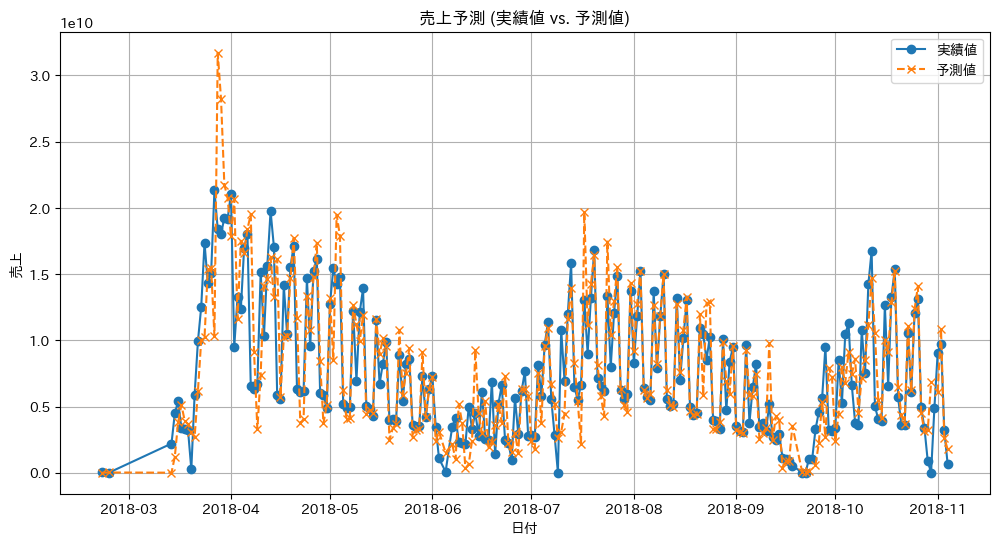

In [ ]:
# daily_data2に予測値を追加
daily_sales['predicted_total_sales_boxcox'] = boxcox_results.predict()

# Box-Cox変換を逆変換して、予測値を元のスケールに戻す
daily_sales['predicted_total_sales'] = inv_boxcox(daily_sales['predicted_total_sales_boxcox'], lambda_)

# 実績値と予測値をプロット
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['total_sales'], label='実績値', marker='o')
plt.plot(daily_sales.index, daily_sales['predicted_total_sales'], label='予測値', marker='x', linestyle='--')
plt.xlabel('日付')
plt.ylabel('売上')
plt.title('売上予測 (実績値 vs. 予測値)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# 実測値（Box-Cox変換後）を取得
y_true_boxcox = daily_sales['total_sales_boxcox']

# 予測値（Box-Cox変換後）を取得
y_pred_boxcox = daily_sales['predicted_total_sales_boxcox']

# RMSEを計算
rmse_boxcox = np.sqrt(mean_squared_error(y_true_boxcox, y_pred_boxcox))

# RMSEを出力
print(f"RMSE (Box-Cox変換後): {rmse_boxcox}")

RMSE (Box-Cox変換後): 51873.67473923275


In [ ]:
from sklearn.metrics import r2_score

# 実績値と予測値を取得
y_true = daily_sales['total_sales_boxcox']
y_pred = daily_sales['predicted_total_sales_boxcox']

# R-squaredを計算
r2 = r2_score(y_true, y_pred)

# R-squaredを出力
print(f'R-squared: {r2}')

R-squared: 0.627352521395664


元データにフィットするモデルの作成ができたため、これから30日分の予測を行う。

In [ ]:
daily_sales

,total_sales,diff1,diff2,diff3,diff4,seasonal_diff,monthly_diff,weekly_diff,weekly_monthly_diff,total_sales_log,total_sales_boxcox,predicted_total_sales_boxcox,predicted_total_sales
date,,,,,,,,,,,,,
2018-02-21,32030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.282184,14210.016426,0.000000,1.000000e+00
2018-02-23,180000,-3.185000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.100712,984.477289,10385.673871,1.742376e+07
2018-03-14,2202300484,2.202120e+09,2.233970e+09,NaN,NaN,NaN,NaN,NaN,NaN,21.512768,125492.693091,4551.017869,3.510608e+06
2018-03-15,4479008974,2.276708e+09,7.458801e+07,-2.159382e+09,NaN,NaN,NaN,NaN,NaN,22.222668,180865.643105,91965.672830,1.204178e+09
2018-03-16,5386645987,9.076370e+08,-1.369071e+09,-1.443659e+09,7.157230e+08,NaN,NaN,NaN,NaN,22.407189,198891.381508,166085.694998,3.795534e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31,4871998000,4.869928e+09,5.727319e+09,4.103032e+09,1.586108e+09,-1.213102e+09,1.484428e+09,-1.213102e+09,-3.555057e+09,22.306770,188869.486101,-15347.701076,NaN
2018-11-01,9071854998,4.199857e+09,-6.700710e+08,-6.397390e+09,-1.050042e+10,-2.980118e+09,5.938550e+08,-2.980118e+09,-8.185758e+09,22.928443,260118.269660,211616.156936,6.076150e+09
2018-11-02,9744695000,6.728400e+08,-3.527017e+09,-2.856946e+09,3.540444e+09,-3.364660e+09,4.510415e+09,-3.364660e+09,-4.024490e+09,22.999989,269878.899535,285522.035294,1.087167e+10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


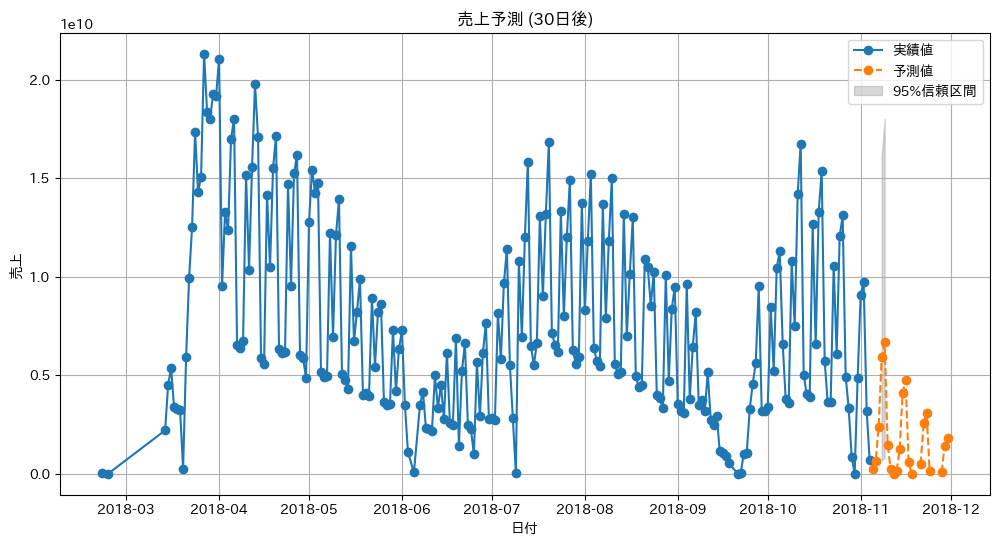

In [ ]:
# Box-Cox変換
data_transformed, lambda_ = stats.boxcox(daily_sales['total_sales'])
daily_sales['total_sales_boxcox'] = data_transformed

# SARIMAモデルの構築 (変換後のデータを使用)
model = sm.tsa.SARIMAX(daily_sales['total_sales_boxcox'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 7))
results = model.fit()

# 予測 (変換後のスケールで取得)
forecast = results.get_forecast(steps=30)
mean_forecast_boxcox = forecast.predicted_mean
confidence_intervals = forecast.conf_int() # 信頼区間を取得

# 逆変換 (元のスケールに戻す)
mean_forecast = inv_boxcox(mean_forecast_boxcox, lambda_)
confidence_intervals = inv_boxcox(confidence_intervals, lambda_) # 信頼区間を逆変換

# 予測結果のインデックスをDatetimeIndexに変換
# 最後の観測日付を取得
last_date = daily_sales.index[-1]

# 予測期間の日付範囲を作成
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')

# 予測結果のインデックスを置き換え
mean_forecast.index = forecast_dates
confidence_intervals.index = forecast_dates


# 可視化
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['total_sales'], label='実績値', marker='o')
plt.plot(mean_forecast.index, mean_forecast.values, label='予測値', marker='o', linestyle='--')
plt.fill_between(forecast_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='gray', alpha=0.3, label='95%信頼区間')  # 信頼区間を塗りつぶしで表示
plt.xlabel('日付')
plt.ylabel('売上')
plt.title('売上予測 (30日後)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 結果の予測値を表示
print("予測値:")
print(mean_forecast)

予測値:
2018-11-05    2.271322e+08
2018-11-06    6.404595e+08
2018-11-07    2.355632e+09
2018-11-08    5.933497e+09
2018-11-09    6.693142e+09
2018-11-10    1.451201e+09
2018-11-11    2.645864e+08
2018-11-12    7.305009e+06
2018-11-13    1.379474e+08
2018-11-14    1.246458e+09
2018-11-15    4.096458e+09
2018-11-16    4.735027e+09
2018-11-17    6.125534e+08
2018-11-18    5.704505e+06
2018-11-19             NaN
2018-11-20             NaN
2018-11-21    4.805991e+08
2018-11-22    2.590615e+09
2018-11-23    3.106673e+09
2018-11-24    1.248698e+08
2018-11-25             NaN
2018-11-26             NaN
2018-11-27             NaN
2018-11-28    6.843359e+07
2018-11-29    1.420557e+09
2018-11-30    1.812274e+09
2018-12-01             NaN
2018-12-02             NaN
2018-12-03             NaN
2018-12-04             NaN
Freq: D, Name: predicted_mean, dtype: float64


精度が悪いため、うまく予測することができていない。

# それでは今回作成した日ごとに集計した売上が入ったdaily_salesをベンチマークとし、特徴量エンジニアリングを行っていく。

In [ ]:
# このデータをベンチマークとする
boxcox_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                  total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -2765.237
Date:                             Thu, 19 Dec 2024   AIC                           5538.474
Time:                                     21:15:37   BIC                           5552.156
Sample:                                          0   HQIC                          5543.995
                                             - 234                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3641      0.057     -6.336      0.000      -0.477      -0.251
ma.L2         -0.2008      0.078     -2.561      0.010      -0.354      -0.047
ma.S.L7       -0.4842      0.072     -6.713      0.000      -0.626      -0.343
sigma2      2.881e+09   7.14e-12   4.04e+20      0.000    2.88e+09    2.88e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                84.25
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.27
Prob(H) (two-sided):                  0.70   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+36. Standard errors may be unstable.
"""

In [ ]:
# 曜日情報をdaily_salesに追加していく。
daily_sales['day_of_week'] = daily_sales.index.dayofweek

# ダミー変数化
daily_sales = pd.get_dummies(daily_sales, columns=['day_of_week'], prefix='dow')

In [ ]:
daily_sales.head()

,total_sales,diff1,diff2,diff3,diff4,seasonal_diff,monthly_diff,weekly_diff,weekly_monthly_diff,total_sales_log,total_sales_boxcox,predicted_total_sales_boxcox,predicted_total_sales,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
date,,,,,,,,,,,,,,,,,,,,
2018-02-21,32030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.282184,14210.016426,0.000000,1.000000e+00,False,False,True,False,False,False,False
2018-02-23,180000,-3.185000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.100712,984.477289,10385.673871,1.742376e+07,False,False,False,False,True,False,False
2018-03-14,2202300484,2.202120e+09,2.233970e+09,NaN,NaN,NaN,NaN,NaN,NaN,21.512768,125492.693091,4551.017869,3.510608e+06,False,False,True,False,False,False,False
2018-03-15,4479008974,2.276708e+09,7.458801e+07,-2.159382e+09,NaN,NaN,NaN,NaN,NaN,22.222668,180865.643105,91965.672830,1.204178e+09,False,False,False,True,False,False,False
2018-03-16,5386645987,9.076370e+08,-1.369071e+09,-1.443659e+09,715722995.0,NaN,NaN,NaN,NaN,22.407189,198891.381508,166085.694998,3.795534e+09,False,False,False,False,True,False,False


In [ ]:
# 外部変数として使用する特徴量を準備
exog_data = daily_sales[['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']]  # 曜日ダミー変数

# exog_dataのデータ型をintに変換
exog_data = exog_data.astype(int)

# SARIMAモデルの構築
model = sm.tsa.SARIMAX(daily_sales['total_sales_boxcox'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 7), exog=exog_data)
results = model.fit()

# 予測
forecast = results.get_forecast(steps=30, exog=exog_data[-30:])  # 予測期間に対応する外部変数も指定

results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                  total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -2760.129
Date:                             Thu, 19 Dec 2024   AIC                           5542.258
Time:                                     21:04:17   BIC                           5579.884
Sample:                                          0   HQIC                          5557.442
                                             - 234                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_0      -5070.3834   7.57e+04     -0.067      0.947   -1.54e+05    1.43e+05
dow_1      -1.356e+04   7.81e+04     -0.174      0.862   -1.67e+05     1.4e+05
dow_2       7295.2262   7.73e+04      0.094      0.925   -1.44e+05    1.59e+05
dow_3       7299.9396   7.41e+04      0.099      0.921   -1.38e+05    1.52e+05
dow_4       3.046e+04   7.13e+04      0.427      0.669   -1.09e+05     1.7e+05
dow_5       -513.8200   7.36e+04     -0.007      0.994   -1.45e+05    1.44e+05
dow_6      -2.591e+04   7.38e+04     -0.351      0.725   -1.71e+05    1.19e+05
ma.L1         -0.4008      0.061     -6.548      0.000      -0.521      -0.281
ma.L2         -0.1438      0.086     -1.666      0.096      -0.313       0.025
ma.S.L7       -0.5286      0.075     -7.064      0.000      -0.675      -0.382
sigma2      2.816e+09     31.085   9.06e+07      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               101.99
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.34
Prob(H) (two-sided):                  0.87   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.92e+24. Standard errors may be unstable.
"""

AICが上がったため、特徴量としては却下する。

### チケット販売数からキャンセル数を引いて来場者数(チケット実販売数)の特徴量を作成する。

In [ ]:
cinema['actual_tickets_sales'] = cinema['tickets_sold'] - cinema['tickets_out']
cinema.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day,actual_tickets_sales
date,,,,,,,,,,,,,,
2018-05-05,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,5,2,5,26
2018-05-05,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,5,2,5,42
2018-05-05,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,5,2,5,32
2018-05-05,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,5,2,5,12
2018-05-05,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,5,2,5,15


In [ ]:
# 1. 日毎の来場者数を集計
daily_attendance = cinema.groupby('date')['actual_tickets_sales'].sum().reset_index()

# 2. 来場者数データと既存のデータフレームを結合
daily_data = pd.merge(daily_sales, daily_attendance, on='date', how='left')

# 3. total_sales を Box-Cox 変換
daily_data['total_sales_boxcox'], lambda_ = stats.boxcox(daily_data['total_sales'])

# auto_arima でパラメータを選定 (Box-Cox 変換後のデータを使用)
model = pm.auto_arima(daily_data['total_sales_boxcox'],
                      seasonal=True, m=7,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action='ignore')  # エラーを無視

# 選定されたパラメータを表示
print(model.order, model.seasonal_order)

# SARIMAモデルを作成 (Box-Cox 変換後のデータと特徴量を使用)
exog_cols = [col for col in daily_data.columns if 'film_code_' in col or col == 'mean_occu_perc_by_screen_code' or col == 'actual_tickets_sales']
sarima_model = sm.tsa.SARIMAX(daily_data['total_sales_boxcox'],
                              order=model.order,
                              seasonal_order=model.seasonal_order,
                              exog=daily_data[exog_cols])


# モデルの学習
sarima_results = sarima_model.fit()

sarima_results.summary()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

(3, 1, 2) (2, 0, 0, 7)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -2710.760
Date:                            Thu, 19 Dec 2024   AIC                           5439.520
Time:                                    21:05:09   BIC                           5470.579
Sample:                                         0   HQIC                          5452.044
                                            - 234                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
actual_tickets_sales     1.3465      0.080     16.814      0.000       1.190       1.503
ar.L1                    0.1461      2.225      0.066      0.948      -4.215       4.507
ar.L2                    0.2227      0.971      0.229      0.819      -1.681       2.126
ar.L3                    0.0988      0.332      0.298      0.766      -0.552       0.749
ma.L1                   -0.7126      2.219     -0.321      0.748      -5.062       3.637
ma.L2                   -0.2827      2.213     -0.128      0.898      -4.621       4.055
ar.S.L7                  0.6957      0.068     10.173      0.000       0.562       0.830
ar.S.L14                 0.1795      0.085      2.117      0.034       0.013       0.346
sigma2                 1.08e+09   5.33e-09   2.03e+17      0.000    1.08e+09    1.08e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               230.43
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.49
Prob(H) (two-sided):                  0.68   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.3e+33. Standard errors may be unstable.
"""

In [ ]:
daily_data

,date,total_sales,diff1,diff2,diff3,diff4,seasonal_diff,monthly_diff,weekly_diff,weekly_monthly_diff,total_sales_log,total_sales_boxcox,predicted_total_sales_boxcox,predicted_total_sales,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,actual_tickets_sales
0,2018-02-21,32030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.282184,14210.016426,0.000000,1.000000e+00,False,False,True,False,False,False,False,267
1,2018-02-23,180000,-3.185000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.100712,984.477289,10385.673871,1.742376e+07,False,False,False,False,True,False,False,3
2,2018-03-14,2202300484,2.202120e+09,2.233970e+09,NaN,NaN,NaN,NaN,NaN,NaN,21.512768,125492.693091,4551.017869,3.510608e+06,False,False,True,False,False,False,False,20074
3,2018-03-15,4479008974,2.276708e+09,7.458801e+07,-2.159382e+09,NaN,NaN,NaN,NaN,NaN,22.222668,180865.643105,91965.672830,1.204178e+09,False,False,False,True,False,False,False,41241
4,2018-03-16,5386645987,9.076370e+08,-1.369071e+09,-1.443659e+09,7.157230e+08,NaN,NaN,NaN,NaN,22.407189,198891.381508,166085.694998,3.795534e+09,False,False,False,False,True,False,False,51685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2018-10-31,4871998000,4.869928e+09,5.727319e+09,4.103032e+09,1.586108e+09,-1.213102e+09,1.484428e+09,-1.213102e+09,-3.555057e+09,22.306770,188869.486101,-15347.701076,NaN,False,False,True,False,False,False,False,47585
230,2018-11-01,9071854998,4.199857e+09,-6.700710e+08,-6.397390e+09,-1.050042e+10,-2.980118e+09,5.938550e+08,-2.980118e+09,-8.185758e+09,22.928443,260118.269660,211616.156936,6.076150e+09,False,False,False,True,False,False,False,80563
231,2018-11-02,9744695000,6.728400e+08,-3.527017e+09,-2.856946e+09,3.540444e+09,-3.364660e+09,4.510415e+09,-3.364660e+09,-4.024490e+09,22.999989,269878.899535,285522.035294,1.087167e+10,False,False,False,False,True,False,False,86585
232,2018-11-03,3208490000,-6.536205e+09,-7.209045e+09,-3.682028e+09,-8.250820e+08,-1.721690e+09,-7.244545e+09,-1.721690e+09,-6.569825e+09,21.889066,152321.409436,137628.740955,2.634765e+09,False,False,False,False,False,True,False,45452


AICが5439と下がったため、この特徴量は採用とする

### actual_tickets_salesからtickets_useを割り使用率を算出する。

In [ ]:
# 使用率を計算
cinema['usage_rate'] = cinema['ticket_use'] / cinema['actual_tickets_sales']

# 使用率を計算 (ゼロ除算エラーを回避)
cinema['usage_rate'] = cinema.apply(lambda row: row['ticket_use'] / row['actual_tickets_sales'] if row['actual_tickets_sales'] != 0 else 0, axis=1)

In [ ]:
# 1. 日毎の来場者数を集計
daily_usage_rate = cinema.groupby('date')['usage_rate'].mean().reset_index()

# 2. 来場者数データと既存のデータフレームを結合
daily_data2 = pd.merge(daily_data, daily_usage_rate, on='date', how='left')

# 3. total_sales を Box-Cox 変換
daily_data2['total_sales_boxcox'], lambda_ = stats.boxcox(daily_data2['total_sales'])

# auto_arima でパラメータを選定 (Box-Cox 変換後のデータを使用)
model = pm.auto_arima(daily_data2['total_sales_boxcox'],
                      seasonal=True, m=7,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action='ignore')  # エラーを無視

# 選定されたパラメータを表示
print(model.order, model.seasonal_order)

# SARIMAモデルを作成 (Box-Cox 変換後のデータと特徴量を使用)
exog_cols = [col for col in daily_data2.columns if 'film_code_' in col
             or col == 'usage_rate' or col == 'actual_tickets_sales']
# daily_data2 を使用するように変更
sarima_model = sm.tsa.SARIMAX(daily_data2['total_sales_boxcox'],
                              order=model.order,
                              seasonal_order=model.seasonal_order,
                              exog=daily_data2[exog_cols])


# モデルの学習
sarima_results = sarima_model.fit()

sarima_results.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

(3, 1, 2) (2, 0, 0, 7)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -2818.556
Date:                            Thu, 19 Dec 2024   AIC                           5657.113
Time:                                    21:06:01   BIC                           5691.623
Sample:                                         0   HQIC                          5671.029
                                            - 234                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
actual_tickets_sales     0.7872      0.019     41.001      0.000       0.750       0.825
usage_rate            4.162e+06   3.32e-05   1.25e+11      0.000    4.16e+06    4.16e+06
ar.L1                    0.0176     18.466      0.001      0.999     -36.176      36.211
ar.L2                    0.1292      7.431      0.017      0.986     -14.436      14.694
ar.L3                   -0.0128      0.564     -0.023      0.982      -1.117       1.092
ma.L1                   -0.0164     18.466     -0.001      0.999     -36.210      36.177
ma.L2                   -0.1594      7.411     -0.022      0.983     -14.684      14.365
ar.S.L7                  0.0116      0.006      1.991      0.046       0.000       0.023
ar.S.L14                 0.0117      0.005      2.364      0.018       0.002       0.021
sigma2                1.075e+09   1.81e-06   5.94e+14      0.000    1.08e+09    1.08e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):                 8.46
Prob(Q):                              0.30   Prob(JB):                         0.01
Heteroskedasticity (H):               1.00   Skew:                             0.11
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.73e+31. Standard errors may be unstable.
"""

AICが上がってしまったため、使用率(usage_rate)は却下とする。

### 上映時間あたりの切符単価を求めることで、時間あたりの価格を算出する


In [ ]:
# 上映時間あたりの切符単価を計算
cinema['price_per_time'] = cinema['total_sales'] / (cinema['show_time'] * cinema['actual_tickets_sales'])

# ゼロ除算エラーを回避
cinema['price_per_time'] = cinema.apply(
    lambda row: row['total_sales'] / (row['show_time'] * row['actual_tickets_sales'])
    if (row['show_time'] * row['actual_tickets_sales']) != 0 else 0,
    axis=1
)

In [ ]:
# 日毎の平均切符単価を計算
daily_price_per_minute = cinema.groupby('date')['price_per_time'].mean().reset_index()

# 既存のデータフレームに結合
daily_data2 = pd.merge(daily_data, daily_price_per_minute, on='date', how='left')

# Box-Cox変換
daily_data2['total_sales_boxcox'], lambda_ = stats.boxcox(daily_data2['total_sales'])

# auto_arimaでパラメータを選定
model = pm.auto_arima(daily_data2['total_sales_boxcox'],
                      seasonal=True, m=7,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action='ignore')

# SARIMAモデルを作成
exog_cols = [col for col in daily_data2.columns if 'film_code_' in col
             or col == 'actual_tickets_sales' or col == 'price_per_time']
sarima_model = sm.tsa.SARIMAX(daily_data2['total_sales_boxcox'],
                              order=model.order,
                              seasonal_order=model.seasonal_order,
                              exog=daily_data2[exog_cols])

# モデルの学習
sarima_results = sarima_model.fit()

sarima_results.summary()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 total_sales_boxcox   No. Observations:                  234
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -2698.361
Date:                            Thu, 19 Dec 2024   AIC                           5416.722
Time:                                    21:06:53   BIC                           5451.232
Sample:                                         0   HQIC                          5430.638
                                            - 234                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
actual_tickets_sales     1.3776      0.063     21.848      0.000       1.254       1.501
price_per_time           0.8673      0.215      4.036      0.000       0.446       1.288
ar.L1                   -0.5027      1.295     -0.388      0.698      -3.040       2.035
ar.L2                    0.5021      0.590      0.852      0.394      -0.653       1.658
ar.L3                    0.0930      0.128      0.728      0.466      -0.157       0.343
ma.L1                   -0.0575      1.288     -0.045      0.964      -2.582       2.467
ma.L2                   -0.9381      1.282     -0.732      0.464      -3.450       1.574
ar.S.L7                  0.6766      0.067     10.144      0.000       0.546       0.807
ar.S.L14                 0.1931      0.076      2.540      0.011       0.044       0.342
sigma2                8.242e+08    1.1e-08   7.51e+16      0.000    8.24e+08    8.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               254.30
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.56
Prob(H) (two-sided):                  0.52   Kurtosis:                         8.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.43e+32. Standard errors may be unstable.
"""

AICが5439から5416に下がったため、この特徴量は採用とする。

最後に作成したモデルがホワイトノイズであるか検証する。

In [ ]:
import statsmodels.api as sm

# モデルの学習
sarima_results = sarima_model.fit()

# 残差の取得
residuals = sarima_results.resid

# Ljung-Box 検定の実行
ljung_box_results = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

# 検定結果の表示
print(ljung_box_results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


     lb_stat  lb_pvalue
10  4.063367   0.944443


また、ljung_box検定の結果ホワイトノイズであることが確認できた。

データが正しいか確認するために、これまで作成したチケット実販売数とチケット単価を乗算した価格と、total_salesが一致するか調べる。

In [ ]:
# actual_tickets_sales と ticket_price から total_sales を計算
cinema['total_sales_calculated'] = cinema['actual_tickets_sales'] * cinema['ticket_price']

# 計算値と実測値の差分を計算
cinema['sales_difference'] = cinema['total_sales'] - cinema['total_sales_calculated']

# 差分を表示
print(cinema[['total_sales', 'total_sales_calculated', 'sales_difference']])

# 差分の統計量を表示
print(cinema['sales_difference'].describe())

# 差分が0の行数をカウント
print("差分が0の行数:", cinema[cinema['sales_difference'] == 0].shape[0])

            total_sales  total_sales_calculated  sales_difference
date                                                             
2018-05-05      3900000               3900000.0               0.0
2018-05-05      3360000               3360000.0               0.0
2018-05-05      2560000               2560000.0               0.0
2018-05-05      1200000               1200000.0               0.0
2018-05-05      1200000               1200000.0               0.0
...                 ...                     ...               ...
2018-11-04      1320000               1320000.0               0.0
2018-11-04      1200000               1200000.0               0.0
2018-11-04      1060000               1060000.0               0.0
2018-11-04       600000                600000.0               0.0
2018-11-04       250000                250000.0               0.0

[142524 rows x 3 columns]
count    1.425240e+05
mean     2.044384e+04
std      2.522142e+05
min     -1.192093e-07
25%      0.000000e+00
50%  

14028行で差分があることが確認できた。
また、マイナスの値も確認できたためここを解明していく。

In [ ]:
cinema.describe()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day,actual_tickets_sales,usage_rate,price_per_time,total_sales_calculated,sales_difference
count,142524.000000,142524.000000,1.425240e+05,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,142524.000000,1.425240e+05,1.425240e+05,1.425240e+05
mean,1518.985111,320.378427,1.234728e+07,140.137570,0.237413,3.932103,19.968232,81234.599886,139.900157,854.401198,6.776852,2.634721,16.112585,139.900157,0.999818,3.165505e+04,1.232683e+07,2.044384e+04
std,36.184450,159.701229,3.065486e+07,279.758733,2.923206,3.056276,22.644279,33236.599278,279.564935,952.768703,2.195843,0.809692,8.949471,279.564935,0.013505,2.604257e+04,3.063162e+07,2.522142e+05
min,1471.000000,32.000000,2.000000e+04,1.000000,0.000000,1.000000,0.000000,483.870968,-219.000000,-2.000000,2.000000,1.000000,1.000000,-219.000000,0.000000,-4.425000e+05,-2.550000e+07,-1.192093e-07
25%,1485.000000,181.000000,1.260000e+06,18.000000,0.000000,2.000000,3.760000,60000.000000,18.000000,277.553256,5.000000,2.000000,8.000000,18.000000,1.000000,1.500000e+04,1.260000e+06,0.000000e+00
50%,1498.000000,324.000000,3.720000e+06,50.000000,0.000000,3.000000,10.370000,79454.235185,50.000000,524.984187,7.000000,3.000000,16.000000,50.000000,1.000000,2.500000e+04,3.710000e+06,0.000000e+00
75%,1556.000000,474.000000,1.110000e+07,143.000000,0.000000,5.000000,28.200000,100000.000000,143.000000,1037.746584,9.000000,3.000000,24.000000,143.000000,1.000000,4.000000e+04,1.110000e+07,0.000000e+00
max,1589.000000,637.000000,1.262820e+09,8499.000000,311.000000,60.000000,147.500000,700000.000000,8499.000000,9692.097160,11.000000,4.000000,31.000000,8499.000000,1.000000,1.560000e+06,1.262820e+09,2.640000e+07


要約統計量を再度確認するとtickets_out	の最大値が311枚であるため、actual_tickets_salesの最小値が-219になっていることが確認できた。

In [ ]:
# actual_tickets_salesの値がマイナスになっている行を抽出
negative_actual_tickets_sales = cinema[cinema['actual_tickets_sales'] < 0]
print(negative_actual_tickets_sales)

            film_code  cinema_code  total_sales  tickets_sold  tickets_out  \
date                                                                         
2018-07-15       1498           72       600000             5           16   
2018-08-11       1498          225      1050000            15           20   
2018-08-10       1498          225      1190000            17           20   
2018-07-31       1498          476      2850000            57           75   
2018-05-24       1494          501       750000            25           41   
...               ...          ...          ...           ...          ...   
2018-10-11       1556          359      1620000            61          100   
2018-09-18       1556          427       400000             5           13   
2018-09-13       1556          427      1200000             8            9   
2018-09-06       1556          225      1435000            24           25   
2018-08-12       1556          225      1120000            16   

61回もチケット使用回数がマイナスになっていることが確認できた。
つまり、61回チケット返却が上回っており、マイナスの売上になっている。

常識的に考えるとチケットキャンセルが上回ることはありえないので、カウントできていないチケット販売数(ネット購入や他のサイトからの購入など他の購入ルート)があるのではないか。
⇒この要因についてはクライアントへヒアリングを行いたい。

## 作成したデータを元に元データとのFittingを可視化、RMSEを算出してみる。

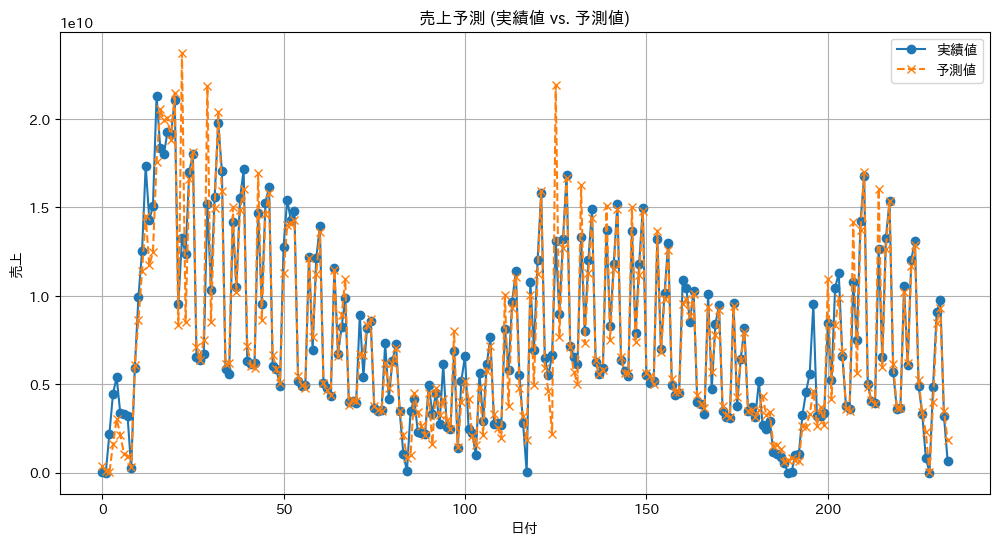

In [ ]:
from scipy.special import inv_boxcox

# daily_data2に予測値を追加
daily_data2['predicted_total_sales_boxcox'] = sarima_results.predict()

# Box-Cox変換を逆変換して、予測値を元のスケールに戻す
daily_data2['predicted_total_sales'] = inv_boxcox(daily_data2['predicted_total_sales_boxcox'], lambda_)

# 実績値と予測値をプロット
plt.figure(figsize=(12, 6))
plt.plot(daily_data2.index, daily_data2['total_sales'], label='実績値', marker='o')
plt.plot(daily_data2.index, daily_data2['predicted_total_sales'], label='予測値', marker='x', linestyle='--')
plt.xlabel('日付')
plt.ylabel('売上')
plt.title('売上予測 (実績値 vs. 予測値)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# 実測値（Box-Cox変換後）を取得
y_true_boxcox = daily_data2['total_sales_boxcox']

# 予測値（Box-Cox変換後）を取得
y_pred_boxcox = daily_data2['predicted_total_sales_boxcox']

# RMSEを計算
rmse_boxcox = np.sqrt(mean_squared_error(y_true_boxcox, y_pred_boxcox))

# RMSEを出力
print(f"RMSE (Box-Cox変換後): {rmse_boxcox}")

RMSE (Box-Cox変換後): 26668.228228446125


In [ ]:
from sklearn.metrics import r2_score

# 実績値と予測値を取得
y_true = daily_data2['total_sales']
y_pred = daily_data2['predicted_total_sales']

# R-squaredを計算
r2 = r2_score(y_true, y_pred)

# R-squaredを出力
print(f'R-squared: {r2}')

R-squared: 0.904973214333548


ベンチマークモデルのR-squared:0.6273 -> 0.9049,RMSE:51873 -> 26668となり、大幅に精度が向上し、モデルを説明できている。

In [ ]:
daily_data2

,date,total_sales,diff1,diff2,diff3,diff4,seasonal_diff,monthly_diff,weekly_diff,weekly_monthly_diff,total_sales_log,total_sales_boxcox,predicted_total_sales_boxcox,predicted_total_sales,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,actual_tickets_sales,price_per_time
0,2018-02-21,32030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.282184,14210.016426,52389.641283,4.036963e+08,False,False,True,False,False,False,False,267,59981.273408
1,2018-02-23,180000,-3.185000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.100712,984.477289,27134.939670,1.124990e+08,False,False,False,False,True,False,False,3,60000.000000
2,2018-03-14,2202300484,2.202120e+09,2.233970e+09,NaN,NaN,NaN,NaN,NaN,NaN,21.512768,125492.693091,9129.514519,1.356508e+07,False,False,True,False,False,False,False,20074,22010.967158
3,2018-03-15,4479008974,2.276708e+09,7.458801e+07,-2.159382e+09,NaN,NaN,NaN,NaN,NaN,22.222668,180865.643105,107346.945464,1.626065e+09,False,False,False,True,False,False,False,41241,23381.757226
4,2018-03-16,5386645987,9.076370e+08,-1.369071e+09,-1.443659e+09,7.157230e+08,NaN,NaN,NaN,NaN,22.407189,198891.381508,148095.310719,3.037857e+09,False,False,False,False,True,False,False,51685,23944.308548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2018-10-31,4871998000,4.869928e+09,5.727319e+09,4.103032e+09,1.586108e+09,-1.213102e+09,1.484428e+09,-1.213102e+09,-3.555057e+09,22.306770,188869.486101,170579.308660,3.997527e+09,False,False,True,False,False,False,False,47585,35352.747034
230,2018-11-01,9071854998,4.199857e+09,-6.700710e+08,-6.397390e+09,-1.050042e+10,-2.980118e+09,5.938550e+08,-2.980118e+09,-8.185758e+09,22.928443,260118.269660,251273.208383,8.482318e+09,False,False,False,True,False,False,False,80563,37554.145974
231,2018-11-02,9744695000,6.728400e+08,-3.527017e+09,-2.856946e+09,3.540444e+09,-3.364660e+09,4.510415e+09,-3.364660e+09,-4.024490e+09,22.999989,269878.899535,263631.393480,9.311339e+09,False,False,False,False,True,False,False,86585,37608.842455
232,2018-11-03,3208490000,-6.536205e+09,-7.209045e+09,-3.682028e+09,-8.250820e+08,-1.721690e+09,-7.244545e+09,-1.721690e+09,-6.569825e+09,21.889066,152321.409436,159317.031320,3.500876e+09,False,False,False,False,False,True,False,45452,27811.656372


In [ ]:
# dateをインデックスに設定
daily_data2.set_index('date', inplace=True)

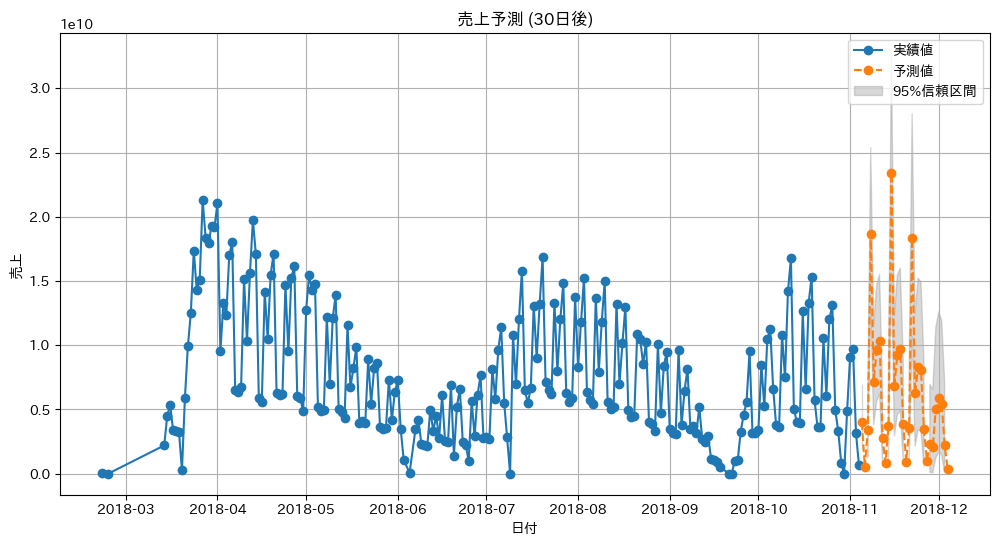

予測値:
234    4.001819e+09
235    5.073575e+08
236    3.426680e+09
237    1.868421e+10
238    7.152636e+09
239    9.627205e+09
240    1.034732e+10
241    2.778647e+09
242    8.344741e+08
243    3.722862e+09
244    2.342945e+10
245    6.850815e+09
246    9.253998e+09
247    9.683434e+09
248    3.878963e+09
249    9.508291e+08
250    3.584276e+09
251    1.835238e+10
252    6.261135e+09
253    8.295403e+09
254    8.084207e+09
255    3.467441e+09
256    1.027633e+09
257    2.275795e+09
258    2.053127e+09
259    5.065194e+09
260    5.911664e+09
261    5.466489e+09
262    2.231443e+09
263    3.801408e+08
Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
from scipy.special import inv_boxcox

# 1. 予測期間の日付範囲を作成
last_date = daily_data2.index[-1]  # daily_data2の最後のインデックスを取得

# 整数インデックスの代わりに、Timestampオブジェクトとして最後の日付を取得します
last_date = pd.to_datetime(last_date)
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')  # 30日後の日付範囲を作成

# 2. 外部変数 (exog_data) を準備
exog_cols = ['actual_tickets_sales', 'price_per_time']  # 外部変数として使用するカラム名

# daily_data2 の最後尾30日分のデータを利用してexog_dataを予測期間に合わせる。
exog_data = daily_data2[exog_cols][-30:].reset_index(drop=True) #reset_index(drop=True)でインデックスをリセット
exog_data.index = forecast_dates #予測期間の日付範囲を新しいindexに設定


# 3. 予測を実行
forecast = sarima_results.get_forecast(steps=30, exog=exog_data)  # 予測を実行
mean_forecast_boxcox = forecast.predicted_mean  # Box-Cox変換後の予測値を取得
confidence_intervals_boxcox = forecast.conf_int()  # Box-Cox変換後の信頼区間を取得

# 4. 予測結果と信頼区間を逆変換
mean_forecast = inv_boxcox(mean_forecast_boxcox, lambda_)  # Box-Cox変換を逆変換
confidence_intervals = inv_boxcox(confidence_intervals_boxcox, lambda_)  # 信頼区間を逆変換

# 5. 予測結果を可視化 (信頼区間を追加)
plt.figure(figsize=(12, 6))
plt.plot(daily_data2.index, daily_data2['total_sales'], label='実績値', marker='o')  # 実績値をプロット
plt.plot(forecast_dates, mean_forecast, label='予測値', marker='o', linestyle='--')  # 予測値をプロット
plt.fill_between(forecast_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='gray', alpha=0.3, label='95%信頼区間')  # 信頼区間を塗りつぶしで表示
plt.xlabel('日付')
plt.ylabel('売上')
plt.title('売上予測 (30日後)')
plt.legend()
plt.grid(True)
plt.show()

# 予測結果を表示
print("予測値:")
print(mean_forecast)

信頼区間の中に予測値が入っており、ベンチマークのデータよりも予測できている。

しかし、前年以前の同時期のデータがないため、予測には不安が残る。

# 【Appendix】現在売上が低下しているため、損益分岐点の上映回数を調査

仮設：1上映あたりで利益が出ているのか。1フィルムコードあたりでチケット単価の幅が広いことにより、マイナスになっている時期もあるのではないか。 利益を出すためには上映期間を何カ月にすれば良いか。

放映権のコストを一定期間内とする

映画をハリウッド、アニメ、インディーズの3つに分ける。

【想定コスト】

◇ハリウッド映画⇒１億

◇アニメ映画⇒5000万

◇インディーズ→1000万

【分類基準】

・フィルムコードの回数が6000回以上ならハリウッド

・フィルムコードの回数が1500回以上ならアニメ

・1500回以下はインディーズ

【算出方法】

・フィルムコード別に数量をカウント＝上映回数

・各フィルムコード×チケット実販売数＝フィルムコード別の売上

・フィルムコード別の売上-コスト＝利益

・上映回数/コスト＝1上映あたりのコスト

In [ ]:
# フィルムコード別に上映回数をカウント
film_counts = cinema['film_code'].value_counts().reset_index()
film_counts.columns = ['film_code', 'show_counts']
cinema = pd.merge(cinema, film_counts, on='film_code', how='left')

In [ ]:
# フィルムコードを元に、映画をハリウッド、アニメ、インディーズの3つに分類し、コストを算出
def categorize_film(row):
       if row['show_counts'] >= 6000:
           return 'ハリウッド', 100000000  # ハリウッド、コスト1億円
       elif row['show_counts'] >= 1500:
           return 'アニメ', 50000000      # アニメ、コスト5000万円
       else:
           return 'インディーズ', 10000000  # インディーズ、コスト1000万円

cinema[['film_category', 'cost']] = cinema.apply(categorize_film, axis=1, result_type="expand")

In [ ]:
# フィルムコード別の売上を計算。
cinema['film_sales'] = cinema['ticket_price'] * cinema['actual_tickets_sales']

利益と1上映あたりのコストを算出

In [ ]:
# 1上映あたりのコストを計算し、小数点以下を切り捨てる
cinema['cost_per_show'] = (cinema['cost'] / cinema['show_counts']).astype(int)

In [ ]:
# フィルムコード別の利益を計算
cinema['profit'] = cinema['film_sales'] - cinema['cost_per_show']

In [ ]:
cinema.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day,actual_tickets_sales,usage_rate,price_per_time,total_sales_calculated,sales_difference,show_counts,film_category,cost,film_sales,cost_per_show,profit
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,5,2,5,26,1.0,37500.000000,3900000.0,0.0,1086,インディーズ,10000000,3900000.0,9208,3890792.0
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,5,2,5,42,1.0,16000.000000,3360000.0,0.0,1086,インディーズ,10000000,3360000.0,9208,3350792.0
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,5,2,5,32,1.0,20000.000000,2560000.0,0.0,1086,インディーズ,10000000,2560000.0,9208,2550792.0
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,5,2,5,12,1.0,100000.000000,1200000.0,0.0,1086,インディーズ,10000000,1200000.0,9208,1190792.0
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,5,2,5,15,1.0,26666.666667,1200000.0,0.0,1086,インディーズ,10000000,1200000.0,9208,1190792.0


In [ ]:
# cinema.to_csv('cinema_processed.csv', index=False)

In [ ]:
# cinema_processed = pd.read_csv('cinema_processed.csv')

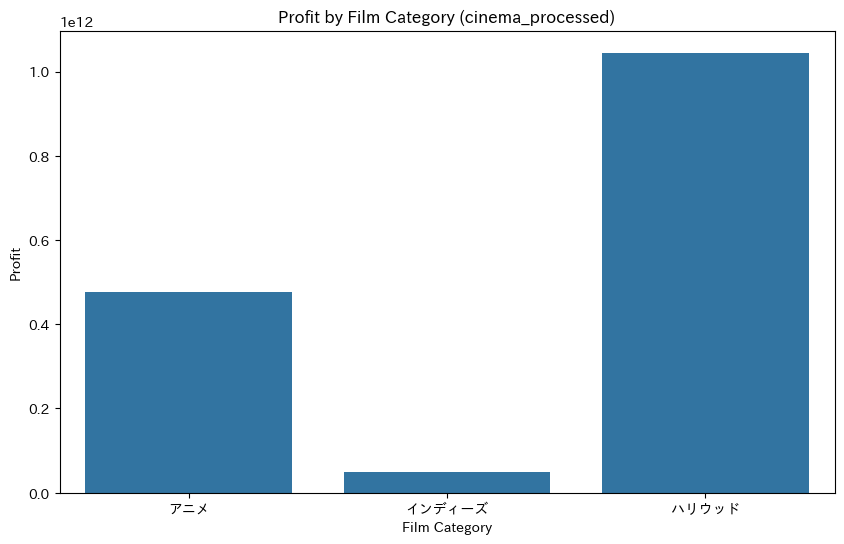

In [ ]:
# film_category ごとの profit を集計
category_profit = cinema_processed.groupby('film_category')['profit'].sum().reset_index()

plt.figure(figsize=(10, 6))  # グラフサイズを設定

# seaborn を使って棒グラフを作成
sns.barplot(x='film_category', y='profit', data=category_profit)

# グラフタイトルと軸ラベルを設定
plt.title('Profit by Film Category (cinema_processed)')
plt.xlabel('Film Category')
plt.ylabel('Profit')

plt.show()  # グラフを表示

フィルムコード毎の利益を可視化していく。

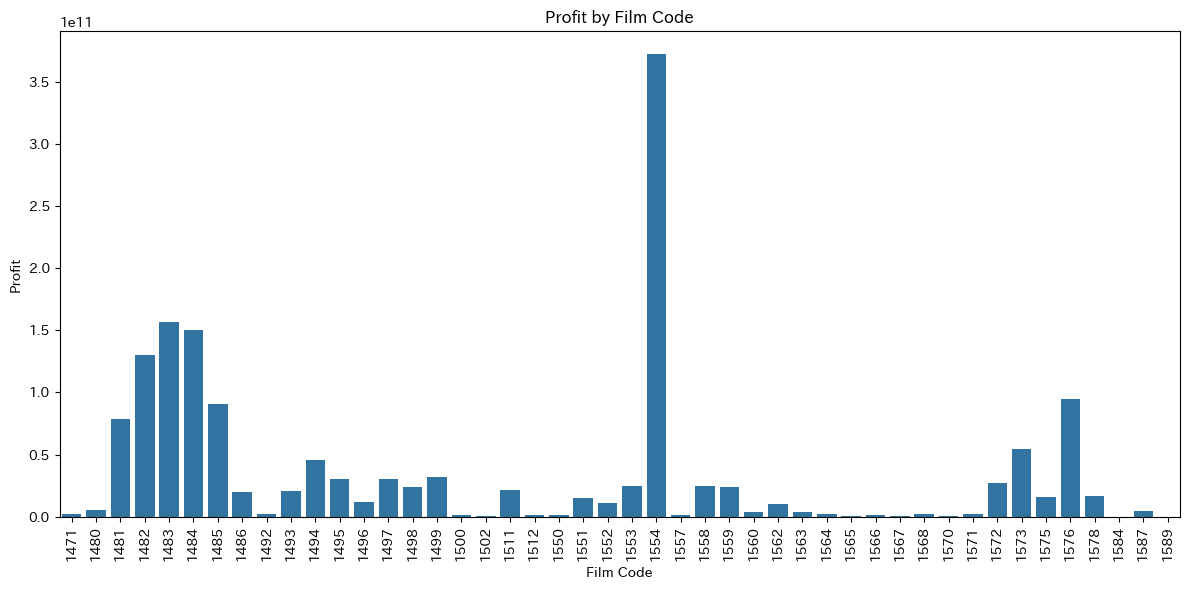

In [ ]:
# film_code ごとの profit を集計
film_profit = cinema_processed.groupby('film_code')['profit'].sum().reset_index()

# グラフを作成
plt.figure(figsize=(12, 6))  # グラフサイズを設定
sns.barplot(x='film_code', y='profit', data=film_profit)  # 棒グラフを作成
plt.title('Profit by Film Code')  # グラフタイトルを設定
plt.xlabel('Film Code')  # x軸ラベルを設定
plt.ylabel('Profit')  # y軸ラベルを設定
plt.xticks(rotation=90)  # x軸の目盛りを回転
plt.tight_layout()  # グラフのレイアウトを調整
plt.show()  # グラフを表示

利益がほとんどないフィルムがあることがわかる。

In [ ]:
cinema_processed

,index,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,actual_tickets_sales,price_per_time,show_counts,film_category,cost,film_sales,profit,cost_per_show,break_even_point,required_shows,required_show_days
0,0,1492,304,3900000,26,0,4,4.26,150000.000000,26,610.328638,2018-05-05,5.0,2.0,5.0,26.0,37500.000000,1086.0,インディーズ,10000000.0,3900000.0,3890792.0,9208.0,62500.0,0.0,0.0
1,1,1492,352,3360000,42,0,5,8.08,80000.000000,42,519.801980,2018-05-05,5.0,2.0,5.0,42.0,16000.000000,1086.0,インディーズ,10000000.0,3360000.0,3350792.0,9208.0,62500.0,0.0,0.0
2,2,1492,489,2560000,32,0,4,20.00,80000.000000,32,160.000000,2018-05-05,5.0,2.0,5.0,32.0,20000.000000,1086.0,インディーズ,10000000.0,2560000.0,2550792.0,9208.0,62500.0,0.0,0.0
3,3,1492,429,1200000,12,0,1,11.01,100000.000000,12,108.991826,2018-05-05,5.0,2.0,5.0,12.0,100000.000000,1086.0,インディーズ,10000000.0,1200000.0,1190792.0,9208.0,62500.0,0.1,0.1
4,4,1492,524,1200000,15,0,3,16.67,80000.000000,15,89.982004,2018-05-05,5.0,2.0,5.0,15.0,26666.666667,1086.0,インディーズ,10000000.0,1200000.0,1190792.0,9208.0,62500.0,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125794,125794,1493,141,16500000,132,0,5,9.81,125000.000000,132,1345.565749,2018-06-18,6.0,2.0,18.0,132.0,25000.000000,10491.0,ハリウッド,100000000.0,16500000.0,16490469.0,9531.0,62500.0,0.0,0.0
125795,125795,1493,513,15940000,161,0,4,16.89,99006.211180,161,953.226761,2018-06-18,6.0,2.0,18.0,161.0,24751.552795,10491.0,ハリウッド,100000000.0,15940000.0,15930469.0,9531.0,62500.0,0.0,0.0
125796,125796,1493,474,15520000,175,0,3,37.88,88685.714286,175,461.985216,2018-06-18,6.0,2.0,18.0,175.0,29561.904762,10491.0,ハリウッド,100000000.0,15520000.0,15510469.0,9531.0,62500.0,0.0,0.0
125797,125797,1493,89,15000000,100,0,7,2.83,150000.000000,100,3533.568905,2018-06-18,6.0,2.0,18.0,100.0,21428.571429,10491.0,ハリウッド,100000000.0,15000000.0,14990469.0,9531.0,62500.0,0.0,0.0


In [ ]:
# フィルムコード毎の上映日数を計算する
# film_code 毎に上映日をユニークにカウント
# cinema_processed = pd.read_csv('cinema_processed.csv', index_col='date') # 'date' をインデックスとして読み込む
cinema_processed = pd.read_csv('cinema_processed.csv')
cinema_processed['date'] = pd.to_datetime(cinema_processed['date']) # 'date' カラムをdatetime型に変換
cinema_processed = cinema_processed.reset_index() # reset_index() を実行する
film_show_days = cinema_processed.groupby('film_code')['date'].nunique().reset_index()

# カラム名を変更
film_show_days.rename(columns={'date': 'show_days'}, inplace=True)

# 結果を表示
print(film_show_days)

    film_code  show_days
0        1471         62
1        1480         98
2        1481        222
3        1482        116
4        1483        152
5        1484        145
6        1485        146
7        1486        100
8        1492         95
9        1493        174
10       1494        113
11       1495         91
12       1496         93
13       1497         95
14       1498        123
15       1499        137
16       1500         67
17       1502         63
18       1511        113
19       1512         65
20       1550         84
21       1551        104
22       1552        116
23       1553         32
24       1554        117
25       1556         86
26       1557         69
27       1558         87
28       1559         98
29       1560         74
30       1562         66
31       1563         57
32       1564         60
33       1565         46
34       1566         44
35       1567         23
36       1568         38
37       1569         39
38       1570         35


◇各フィルムコード毎の損益分岐点 (売上)

損益分岐点 (売上) = 固定費 / (1 - 変動費率)

◇損益分岐点に到達するのに必要な上映回数

必要な上映回数 = 損益分岐点 (売上) / 1上映あたりの売上

In [ ]:
# 固定費
fixed_cost = 50000

# 変動費率
variable_cost_rate = 0.2

# 損益分岐点 (売上) を計算
cinema_processed['break_even_point'] = fixed_cost / (1 - variable_cost_rate)

# 必要な上映回数を計算し、小数点以下1桁まで表示
cinema_processed['required_shows'] = cinema_processed.apply(
    lambda row: round(row['break_even_point'] / row['film_sales'], 1) if row['film_sales'] != 0 else 0,  # round()で四捨五入
    axis=1
)

In [ ]:
# 各フィルムコード毎に必要な上映回数を表示
print(cinema_processed[['film_code', 'required_shows']])

        film_code  required_shows
0            1492             0.0
1            1492             0.0
2            1492             0.0
3            1492             0.1
4            1492             0.1
...           ...             ...
142519       1569             0.0
142520       1569             0.1
142521       1569             0.1
142522       1569             0.1
142523       1569             0.2

[142524 rows x 2 columns]


In [ ]:
# 1日あたりの上映回数を仮定
shows_per_day_by_category = {
    "ハリウッド": 2,
    "アニメ": 1.5,
    "インディーズ": 1
}

# 必要な上映期間 (日数) を計算し、小数点以下1桁で四捨五入
cinema_processed['required_show_days'] = cinema_processed.apply(
lambda row: round(row['required_shows'] / shows_per_day_by_category.get(row['film_category'], 1), 1)
if pd.notna(row['film_category']) else 0,  # film_category が NaN の場合は 0 を代入
axis=1)

# 各フィルムコード毎に必要な上映期間 (日数) を表示
print(cinema_processed[['film_code', 'required_show_days']])

        film_code  required_show_days
0            1492                 0.0
1            1492                 0.0
2            1492                 0.0
3            1492                 0.1
4            1492                 0.1
...           ...                 ...
142519       1569                 0.0
142520       1569                 0.1
142521       1569                 0.1
142522       1569                 0.1
142523       1569                 0.2

[142524 rows x 2 columns]


In [ ]:
# film_code ごとに required_show_days の合計を計算
required_show_days_by_film_code = cinema_processed.groupby('film_code')['required_show_days'].sum().reset_index()

# 結果を表示
print(required_show_days_by_film_code)

    film_code  required_show_days
0        1471                25.6
1        1480                91.8
2        1481               263.4
3        1482               105.0
4        1483               101.6
5        1484               119.7
6        1485               109.3
7        1486                77.9
8        1492               123.6
9        1493               188.7
10       1494               203.1
11       1495                91.5
12       1496                58.6
13       1497               138.8
14       1498               313.2
15       1499               195.7
16       1500                65.3
17       1502                87.2
18       1511               146.5
19       1512                53.2
20       1550                66.5
21       1551                88.3
22       1552               130.0
23       1553                77.5
24       1554               108.7
25       1556               264.7
26       1557                38.9
27       1558               121.4
28       1559 

試算した必要上映回数(required_show_days)と現在の上映回数(film_show_days)を表示させる。

In [ ]:
# required_show_days_by_film_code と film_show_days を結合
merged_data = pd.merge(required_show_days_by_film_code, film_show_days, on='film_code', how='left')

# 結合結果を表示
print(merged_data)

    film_code  required_show_days  show_days
0        1471                25.6         62
1        1480                91.8         98
2        1481               263.4        222
3        1482               105.0        116
4        1483               101.6        152
5        1484               119.7        145
6        1485               109.3        146
7        1486                77.9        100
8        1492               123.6         95
9        1493               188.7        174
10       1494               203.1        113
11       1495                91.5         91
12       1496                58.6         93
13       1497               138.8         95
14       1498               313.2        123
15       1499               195.7        137
16       1500                65.3         67
17       1502                87.2         63
18       1511               146.5        113
19       1512                53.2         65
20       1550                66.5         84
21       1